# Problem statement

Most of the time when we need rainfall data from rainfall stations, not all areas we want to study have rainfall stations, so satellite data is a practical solution to replace the absence of this data. However, of course the estimated data (satellite) will certainly have an error when compared to real measurement data (observation), therefore it takes correction first to use satellite data before being applied to other uses.
Based on Kartika's research, the best method to correct biased rainfall data from observations is to use the quantile mapping method, therefore corrections will be made using the quantile mapping method.

# Objective

- Correcting rainfall data per rainfall classification using quantile mapping
- Calculating rmse and correlation of all correction factors per station
- Determine the best station to be the corrector station per rainfall classification

# Import Librabries

In [1]:
import pandas as pd
from scipy import signal
from scipy import stats
from sklearn.metrics import mean_squared_error
import numpy as np
import pvlib
from scipy import interpolate
from functools import reduce

# Data Loading

In [2]:
# read rainfall satellite data and save it in tmp variable
tmp=pd.read_excel("D:/Happy/RTOW/Pemali Juana/koreksi gpm/CH koreksi/gpm_all.xlsx")

In [3]:
# read rainfall observation data and save it in obs variable
obs=pd.read_excel("D:/Happy/RTOW/Pemali Juana/koreksi gpm/CH koreksi/Dipakai/utk koreksi fix/CH_obsQC.xlsx")
obs=obs.iloc[:,1:]

# save the name of each station
sta=obs.columns[1:].values
sta

array(['B-R.4b-Greneng', 'D-SE.110-Bungo', 'D-SE.117-Buyaran Karangsari',
       'D-SE.124-Guntur', 'D-SE.165-Karanganyar', 'D-SE.166-Ngemplik',
       'G-SE.133-Godong', 'G-SE.199-Gending', 'G-SE.201-Pengkol',
       'G-SE.205b-Semen', 'G-SE.217a-Butak', 'J-SE.106-Kedung',
       'J-SE.143-Bapangan Jepara', 'J-SE.160-Jatisari',
       'J-SE.160-Pelemkerep', 'J-SE.161-Pancur', 'K-SE.129-Beru Genjang',
       'K-SE.158-Besito Kr.malang', 'K-SE.186-Tanjungrejo',
       'P-SE.175-Trangkil', 'P-SE.180a-Brambang pati',
       'P-SE.181a-Gunung Rowo', 'P-SE.183-Langse', 'P-SE.184 Pati',
       'P-SE.191a-Cabean'], dtype=object)

In [4]:
# check the observation data
obs.head()

,date,B-R.4b-Greneng,D-SE.110-Bungo,D-SE.117-Buyaran Karangsari,D-SE.124-Guntur,D-SE.165-Karanganyar,D-SE.166-Ngemplik,G-SE.133-Godong,G-SE.199-Gending,G-SE.201-Pengkol,...,J-SE.161-Pancur,K-SE.129-Beru Genjang,K-SE.158-Besito Kr.malang,K-SE.186-Tanjungrejo,P-SE.175-Trangkil,P-SE.180a-Brambang pati,P-SE.181a-Gunung Rowo,P-SE.183-Langse,P-SE.184 Pati,P-SE.191a-Cabean
0,2011-01-01 00:00:00,3,13.0,1,3,23,29,0,12,12,...,22,3,12,32,0.0,30,0,13,8,30
1,2011-01-02 00:00:00,3,16.0,87,71,29,29,22,18,12,...,0,0,9,13,16.0,0,0,3,0,0
2,2011-01-03 00:00:00,0,29.0,9,4,9,16,6,7,3,...,0,0,2,6,0.0,0,0,0,0,0
3,2011-01-04 00:00:00,0,3.0,9,10,6,5,1,4,0,...,0,0,4,12,0.0,0,0,0,0,0
4,2011-01-05 00:00:00,0,7.0,0,9,1,0,8,19,9,...,0,29,1,0,0.0,0,0,0,0,0


In [7]:
# check the information of observational data
obs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3653 entries, 0 to 3652
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   date                         3653 non-null   object 
 1   B-R.4b-Greneng               3653 non-null   int64  
 2   D-SE.110-Bungo               3652 non-null   float64
 3   D-SE.117-Buyaran Karangsari  3653 non-null   int64  
 4   D-SE.124-Guntur              3653 non-null   int64  
 5   D-SE.165-Karanganyar         3653 non-null   int64  
 6   D-SE.166-Ngemplik            3653 non-null   int64  
 7   G-SE.133-Godong              3653 non-null   int64  
 8   G-SE.199-Gending             3653 non-null   int64  
 9   G-SE.201-Pengkol             3653 non-null   int64  
 10  G-SE.205b-Semen              3653 non-null   int64  
 11  G-SE.217a-Butak              3653 non-null   int64  
 12  J-SE.106-Kedung              3653 non-null   float64
 13  J-SE.143-Bapangan 

We have 25 stations columns with numerical datatype. These data will be used for correcting the satellite data.

In [5]:
# select grid that contain from 
gpm=tmp[['Date','B-R.4b-Greneng', 'D-SE.110-Bungo', 'D-SE.117-Buyaran Karangsari',
       'D-SE.124-Guntur', 'D-SE.165-Karanganyar', 'D-SE.166-Ngemplik',
       'G-SE.133-Godong', 'G-SE.199-Gending', 'G-SE.201-Pengkol',
       'G-SE.205b-Semen', 'G-SE.217a-Butak', 'J-SE.106-Kedung',
       'J-SE.143-Bapangan Jepara', 'J-SE.160-Jatisari',
       'J-SE.160-Pelemkerep', 'J-SE.161-Pancur', 'K-SE.129-Beru Genjang',
       'K-SE.158-Besito Kr.malang', 'K-SE.186-Tanjungrejo',
       'P-SE.175-Trangkil', 'P-SE.180a-Brambang pati',
       'P-SE.181a-Gunung Rowo', 'P-SE.183-Langse', 'P-SE.184 Pati',
       'P-SE.191a-Cabean']]

In [6]:
# check the satellite data
gpm.head()

,Date,B-R.4b-Greneng,D-SE.110-Bungo,D-SE.117-Buyaran Karangsari,D-SE.124-Guntur,D-SE.165-Karanganyar,D-SE.166-Ngemplik,G-SE.133-Godong,G-SE.199-Gending,G-SE.201-Pengkol,...,J-SE.161-Pancur,K-SE.129-Beru Genjang,K-SE.158-Besito Kr.malang,K-SE.186-Tanjungrejo,P-SE.175-Trangkil,P-SE.180a-Brambang pati,P-SE.181a-Gunung Rowo,P-SE.183-Langse,P-SE.184 Pati,P-SE.191a-Cabean
0,2011-01-01,22.847042,21.543657,27.099419,27.099419,13.475302,13.475302,19.973000,17.021173,24.174738,...,21.200468,15.786333,12.094335,15.169107,20.323811,15.040624,15.040624,15.169107,16.495329,14.375852
1,2011-01-02,2.531204,9.319880,11.284864,11.284864,4.896010,4.896010,9.987504,8.319900,9.718975,...,4.587416,7.320039,6.863521,2.963042,0.824990,1.419742,1.419742,2.963042,1.805953,2.723836
2,2011-01-03,0.483813,6.893654,0.824072,0.824072,0.617437,0.617437,0.700520,0.443321,0.822257,...,12.796146,0.684939,5.705787,1.174212,7.354810,3.718790,3.718790,1.174212,0.586788,0.601736
3,2011-01-04,8.368333,4.878605,5.075104,5.075104,7.653893,7.653893,4.061394,3.777418,3.199140,...,2.257871,6.276123,6.794976,6.251758,3.167537,2.887479,2.887479,6.251758,6.043178,9.300513
4,2011-01-05,0.150410,0.635474,2.990502,2.990502,0.647955,0.647955,2.062516,2.432973,2.568286,...,2.091663,1.820345,1.288939,0.938201,0.068242,1.657603,1.657603,0.938201,0.078724,0.141465


In [8]:
# check the information of satellite data
gpm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3653 entries, 0 to 3652
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Date                         3653 non-null   datetime64[ns]
 1   B-R.4b-Greneng               3653 non-null   float64       
 2   D-SE.110-Bungo               3653 non-null   float64       
 3   D-SE.117-Buyaran Karangsari  3653 non-null   float64       
 4   D-SE.124-Guntur              3653 non-null   float64       
 5   D-SE.165-Karanganyar         3653 non-null   float64       
 6   D-SE.166-Ngemplik            3653 non-null   float64       
 7   G-SE.133-Godong              3653 non-null   float64       
 8   G-SE.199-Gending             3653 non-null   float64       
 9   G-SE.201-Pengkol             3653 non-null   float64       
 10  G-SE.205b-Semen              3653 non-null   float64       
 11  G-SE.217a-Butak              3653 non-null 

We have the clean rainfall station data with numerical datatype as well, now we are ready to correct the data.

# Exploratory Data Analysis

<Axes: xlabel='Date'>

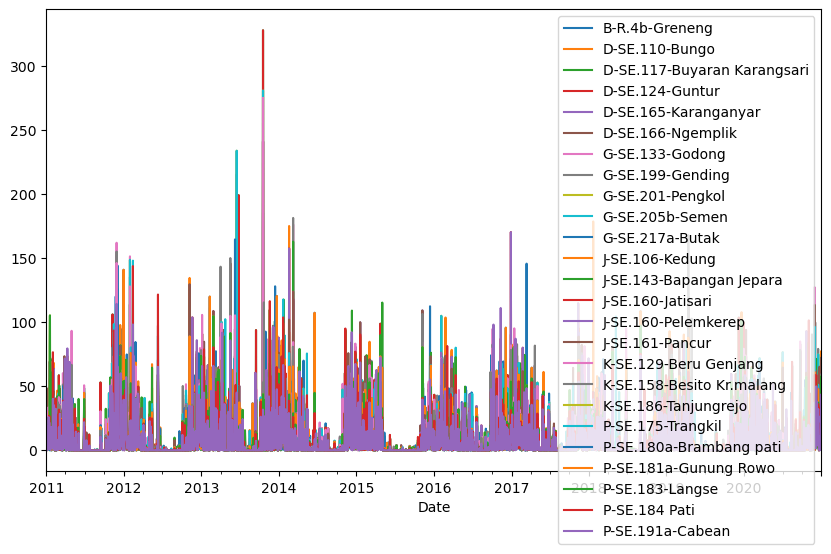

In [9]:
gpm.plot(x="Date", y=obs.columns[1:].values,
        kind="line", figsize=(10, 6))

<Axes: xlabel='Date'>

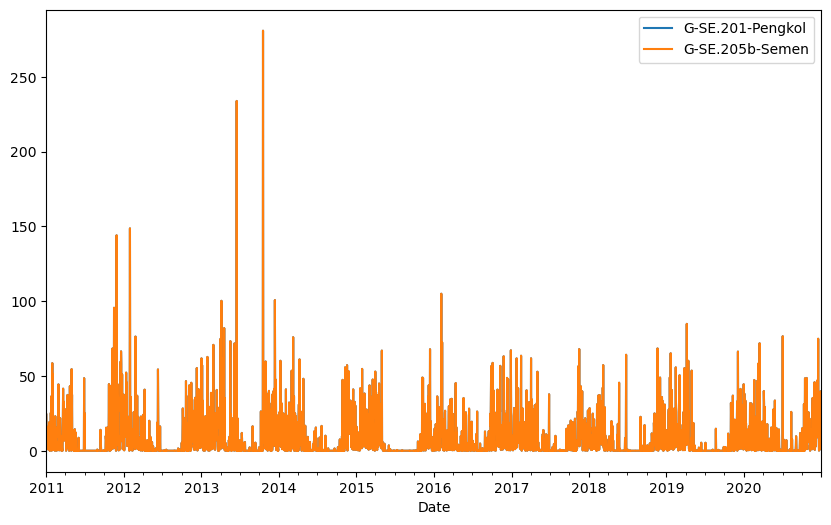

In [10]:
gpm.plot(x="Date", y=["G-SE.201-Pengkol","G-SE.205b-Semen"],
        kind="line", figsize=(10, 6))

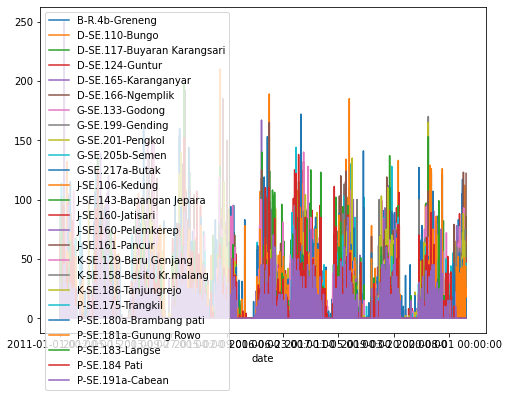

In [76]:
obs.plot(x="date", y=obs.columns[1:].values,
        kind="line", figsize=(8, 6))

In [77]:
obs[obs.iloc[:,25]>250]

,date,B-R.4b-Greneng,D-SE.110-Bungo,D-SE.117-Buyaran Karangsari,D-SE.124-Guntur,D-SE.165-Karanganyar,D-SE.166-Ngemplik,G-SE.133-Godong,G-SE.199-Gending,G-SE.201-Pengkol,...,J-SE.161-Pancur,K-SE.129-Beru Genjang,K-SE.158-Besito Kr.malang,K-SE.186-Tanjungrejo,P-SE.175-Trangkil,P-SE.180a-Brambang pati,P-SE.181a-Gunung Rowo,P-SE.183-Langse,P-SE.184 Pati,P-SE.191a-Cabean


In [78]:
sta[19]

'P-SE.175-Trangkil'

# Quantile Mapping

In [75]:
# define the function
def ecdf(x): # empirical CDF computation
    xs = np.sort(x)
    ys = np.arange(1, len(xs)+1)/float(len(xs))
    return xs, ys

def QuantileMappinBR(y_obs,y_mod): # Bias Removal using empirical quantile mapping
    y_cor = y_mod
    x_obs,cdf_obs = ecdf(y_obs)
    x_mod,cdf_mod = ecdf(y_mod)
    # Translate data to the quantile domain, apply the CDF operator
    cdf = interpolate.interp1d(x_mod,cdf_mod,kind='nearest',fill_value='extrapolate')
    qtile = cdf(y_mod)
    # Apply de CDF^-1 operator to reverse the operation to radiation domain
    cdfinv = interpolate.interp1d(cdf_obs,x_obs,kind='nearest',fill_value='extrapolate')
    y_cor = cdfinv(qtile)
    return y_cor

## CH Lebat

#### Script dibalik, gpm dulu baru obs

In [13]:
tabel_performa=pd.DataFrame(columns=['stasiun','rmse','rmse corr','rmse wo otl','rmse wo otl corr',\
                                     'korelasi','korelasi corr','korelasi wo otl','korelasi wo otl corr'])
sta=pd.ExcelFile('D:/Happy/RTOW/Pemali Juana/koreksi gpm/ch klasifikasi acuan/qc_Lebat.xlsx')
sta_name=sta.sheet_names
for i in range (len(sta_name)):
    globals()['st'+str(i)]=pd.read_excel('D:/Happy/RTOW/Pemali Juana/koreksi gpm/ch klasifikasi acuan/qc_Lebat.xlsx',\
              sheet_name=sta_name[i])
    globals()['st'+str(i)]=globals()['st'+str(i)].dropna()
    obs_st=globals()['st'+str(i)].iloc[:,3]
    gpm_st=globals()['st'+str(i)].iloc[:,1]

    r1,p1=stats.pearsonr(obs_st, gpm_st)
    rmse1=mean_squared_error(obs_st, gpm_st)

    #quantileMapping Bias Correction
    gpm_corr=QuantileMappinBR(gpm_st,obs_st)
    r2,p2=stats.pearsonr(obs_st, gpm_corr)
    rmse2=mean_squared_error(obs_st, gpm_corr)
    globals()['st'+str(i)]['gpm corr']=gpm_corr

    #without outlier
    sss=globals()['st'+str(i)]
    globals()['st'+str(i)+'wo_otl']=sss[(sss.iloc[:,3]<250) & (sss.iloc[:,1]<250)]

    obs_st_wo_otl=globals()['st'+str(i)+'wo_otl'].iloc[:,3]
    gpm_st_wo_otl=globals()['st'+str(i)+'wo_otl'].iloc[:,1]
    r3,p3=stats.pearsonr(obs_st_wo_otl, gpm_st_wo_otl)
    rmse3=mean_squared_error(obs_st_wo_otl, gpm_st_wo_otl)

    #quantileMapping Bias Correction without outlier
    gpm_corr_wo_otl=QuantileMappinBR(gpm_st_wo_otl, obs_st_wo_otl)
    r4,p4=stats.pearsonr(obs_st_wo_otl, gpm_corr_wo_otl)
    rmse4=mean_squared_error(obs_st_wo_otl, gpm_corr_wo_otl)
    globals()['st'+str(i)+'wo_otl']['gpm corr wo otl']=gpm_corr_wo_otl


    tabel_performa=tabel_performa.append(pd.DataFrame([{"stasiun":sta_name[i],
                    'rmse':rmse1,'rmse corr':rmse2,'rmse wo otl':rmse3,'rmse wo otl corr':rmse4,\
                    'korelasi':r1,'korelasi corr':r2,\
                    'korelasi wo otl':r3,'korelasi wo otl corr':r4}]))

tabel_performa=tabel_performa.reset_index()
tabel_performa=tabel_performa.iloc[:,1:]
tabel_performa

,stasiun,rmse,rmse corr,rmse wo otl,rmse wo otl corr,korelasi,korelasi corr,korelasi wo otl,korelasi wo otl corr
0,B-R.4b-Greneng,3262.957304,2982.021593,3262.957304,2982.021593,0.134275,0.958443,0.134275,0.958443
1,D-SE.110-Bungo,3005.814551,2239.312833,3005.814551,2239.312833,0.038844,0.895380,0.038844,0.895380
2,D-SE.117-Buyaran Karangsari,3155.326205,2408.458016,3155.326205,2408.458016,-0.103565,0.950411,-0.103565,0.950411
3,D-SE.124-Guntur,3327.866657,2566.532236,3327.866657,2566.532236,0.113885,0.888991,0.113885,0.888991
4,D-SE.165-Karanganyar,3454.079080,2681.820983,3454.079080,2681.820983,-0.090312,0.872748,-0.090312,0.872748
5,D-SE.166-Ngemplik,3127.581926,2365.656704,3127.581926,2365.656704,0.088460,0.907514,0.088460,0.907514
6,G-SE.133-Godong,3963.426491,3203.421283,3963.426491,3203.421283,-0.100237,0.844809,-0.100237,0.844809
7,G-SE.199-Gending,3812.482792,3110.587326,3812.482792,3110.587326,0.221662,0.945833,0.221662,0.945833
8,G-SE.201-Pengkol,3506.401105,2835.872605,3506.401105,2835.872605,-0.220160,0.950972,-0.220160,0.950972
9,G-SE.205b-Semen,3299.798517,2729.315360,3299.798517,2729.315360,-0.142454,0.879464,-0.142454,0.879464


In [14]:
## J-SE.106-Kedung kategori lebat (inverse) indeks ke-11

In [15]:
tabel_performa=pd.DataFrame(columns=['stasiun','rmse','rmse corr','rmse wo otl','rmse wo otl corr',\
                                     'korelasi','korelasi corr','korelasi wo otl','korelasi wo otl corr'])
sta=pd.ExcelFile('D:/Happy/RTOW/Pemali Juana/koreksi gpm/ch klasifikasi acuan/qc_lebat.xlsx')
sta_name=sta.sheet_names
sta_name

for i in range (len(sta_name)):
    globals()['st'+str(i)]=pd.read_excel('D:/Happy/RTOW/Pemali Juana/koreksi gpm/ch klasifikasi acuan/qc_lebat.xlsx',\
              sheet_name=sta_name[i])
    globals()['st'+str(i)]=globals()['st'+str(i)].dropna()
    obs_st=globals()['st'+str(i)].iloc[:,3]
    gpm_st=globals()['st'+str(i)].iloc[:,1]
    try:
        r1,p1=stats.pearsonr(obs_st, gpm_st)
        rmse1=mean_squared_error(obs_st, gpm_st)

        #quantileMapping Bias Correction
        gpm_corr=QuantileMappinBR(obs_st,gpm_st)
        r2,p2=stats.pearsonr(obs_st, gpm_corr)
        rmse2=mean_squared_error(obs_st, gpm_corr)

        #without outlier
        sss=globals()['st'+str(i)]
        globals()['st'+str(i)+'wo_otl']=sss[(sss.iloc[:,3]<250) & (sss.iloc[:,1]<250)]

        obs_st_wo_otl=globals()['st'+str(i)+'wo_otl'].iloc[:,3]
        gpm_st_wo_otl=globals()['st'+str(i)+'wo_otl'].iloc[:,1]
        r3,p3=stats.pearsonr(obs_st_wo_otl, gpm_st_wo_otl)
        rmse3=mean_squared_error(obs_st_wo_otl, gpm_st_wo_otl)

        #quantileMapping Bias Correction without outlier
        gpm_corr_wo_otl=QuantileMappinBR(obs_st_wo_otl, gpm_st_wo_otl)
        r4,p4=stats.pearsonr(obs_st_wo_otl, gpm_corr_wo_otl)
        rmse4=mean_squared_error(obs_st_wo_otl, gpm_corr_wo_otl)


        tabel_performa=tabel_performa.append(pd.DataFrame([{"stasiun":sta_name[i],
                        'rmse':rmse1,'rmse corr':rmse2,'rmse wo otl':rmse3,'rmse wo otl corr':rmse4,\
                        'korelasi':r1,'korelasi corr':r2,\
                        'korelasi wo otl':r3,'korelasi wo otl corr':r4}]))
    except:
        print (sta_name[i]+" cannot be corrected")
tabel_performa=tabel_performa.reset_index()
tabel_performa=tabel_performa.iloc[:,1:]
tabel_performa

,stasiun,rmse,rmse corr,rmse wo otl,rmse wo otl corr,korelasi,korelasi corr,korelasi wo otl,korelasi wo otl corr
0,B-R.4b-Greneng,3262.957304,79.822222,3262.957304,79.822222,0.134275,0.140304,0.134275,0.140304
1,D-SE.110-Bungo,3005.814551,1633.090909,3005.814551,1633.090909,0.038844,0.081472,0.038844,0.081472
2,D-SE.117-Buyaran Karangsari,3155.326205,956.533333,3155.326205,956.533333,-0.103565,-0.084959,-0.103565,-0.084959
3,D-SE.124-Guntur,3327.866657,1361.433333,3327.866657,1361.433333,0.113885,0.074824,0.113885,0.074824
4,D-SE.165-Karanganyar,3454.079080,1280.272727,3454.079080,1280.272727,-0.090312,-0.106214,-0.090312,-0.106214
5,D-SE.166-Ngemplik,3127.581926,1214.969697,3127.581926,1214.969697,0.088460,0.104084,0.088460,0.104084
6,G-SE.133-Godong,3963.426491,407.687500,3963.426491,407.687500,-0.100237,-0.099677,-0.100237,-0.099677
7,G-SE.199-Gending,3812.482792,116.156250,3812.482792,116.156250,0.221662,0.222548,0.221662,0.222548
8,G-SE.201-Pengkol,3506.401105,171.044776,3506.401105,171.044776,-0.220160,-0.164571,-0.220160,-0.164571
9,G-SE.205b-Semen,3299.798517,461.582090,3299.798517,461.582090,-0.142454,-0.083679,-0.142454,-0.083679


In [16]:
#stasiun G-SE.199-Gending utk kategori lebat (indeks ke 7)

In [17]:
tabel_performa.describe()

,rmse,rmse corr,rmse wo otl,rmse wo otl corr,korelasi,korelasi corr,korelasi wo otl,korelasi wo otl corr
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,3153.693010,1128.314575,3153.693010,1128.314575,0.037907,0.043110,0.037907,0.043110
std,448.672471,733.371756,448.672471,733.371756,0.131315,0.115852,0.131315,0.115852
min,2098.954324,79.822222,2098.954324,79.822222,-0.221233,-0.169347,-0.221233,-0.169347
25%,2926.247489,461.582090,2926.247489,461.582090,-0.014252,-0.052554,-0.014252,-0.052554
50%,3127.581926,1214.969697,3127.581926,1214.969697,0.044348,0.040763,0.044348,0.040763
75%,3335.803220,1413.451613,3335.803220,1413.451613,0.119357,0.104084,0.119357,0.104084
max,4008.235747,2898.047059,4008.235747,2898.047059,0.277899,0.258130,0.277899,0.258130


In [18]:
st1

,date,gpm,Klasifikasi,D-SE.110-Bungo
0,2011-02-05,68.171555,Lebat,29
1,2011-11-27,61.804020,Lebat,0
2,2011-12-16,69.669083,Lebat,53
3,2012-01-30,51.724541,Lebat,4
4,2012-02-26,79.855118,Lebat,24
...,...,...,...,...
72,2020-11-29,66.445221,Lebat,0
73,2020-12-06,61.907074,Lebat,27
74,2020-12-07,52.181946,Lebat,95
75,2020-12-19,54.944561,Lebat,12


## CH Sangat Lebat

#### Script dibalik, gpm dulu baru obs

In [19]:
tabel_performa=pd.DataFrame(columns=['stasiun','rmse','rmse corr','rmse wo otl','rmse wo otl corr',\
                                     'korelasi','korelasi corr','korelasi wo otl','korelasi wo otl corr'])
sta=pd.ExcelFile('D:/Happy/RTOW/Pemali Juana/koreksi gpm/ch klasifikasi acuan/qc_Sangat_Lebat.xlsx')
sta_name=sta.sheet_names
for i in range (len(sta_name)):
    globals()['st'+str(i)]=pd.read_excel('D:/Happy/RTOW/Pemali Juana/koreksi gpm/ch klasifikasi acuan/qc_Sangat_Lebat.xlsx',\
              sheet_name=sta_name[i])
    globals()['st'+str(i)]=globals()['st'+str(i)].dropna()
    obs_st=globals()['st'+str(i)].iloc[:,3]
    gpm_st=globals()['st'+str(i)].iloc[:,1]

    r1,p1=stats.pearsonr(obs_st, gpm_st)
    rmse1=mean_squared_error(obs_st, gpm_st)

    #quantileMapping Bias Correction
    gpm_corr=QuantileMappinBR(gpm_st,obs_st)
    r2,p2=stats.pearsonr(obs_st, gpm_corr)
    rmse2=mean_squared_error(obs_st, gpm_corr)
    globals()['st'+str(i)]['gpm corr']=gpm_corr

    #without outlier
    sss=globals()['st'+str(i)]
    globals()['st'+str(i)+'wo_otl']=sss[(sss.iloc[:,3]<250) & (sss.iloc[:,1]<250)]

    obs_st_wo_otl=globals()['st'+str(i)+'wo_otl'].iloc[:,3]
    gpm_st_wo_otl=globals()['st'+str(i)+'wo_otl'].iloc[:,1]
    r3,p3=stats.pearsonr(obs_st_wo_otl, gpm_st_wo_otl)
    rmse3=mean_squared_error(obs_st_wo_otl, gpm_st_wo_otl)

    #quantileMapping Bias Correction without outlier
    gpm_corr_wo_otl=QuantileMappinBR(gpm_st_wo_otl, obs_st_wo_otl)
    r4,p4=stats.pearsonr(obs_st_wo_otl, gpm_corr_wo_otl)
    rmse4=mean_squared_error(obs_st_wo_otl, gpm_corr_wo_otl)
    globals()['st'+str(i)+'wo_otl']['gpm corr wo otl']=gpm_corr_wo_otl


    tabel_performa=tabel_performa.append(pd.DataFrame([{"stasiun":sta_name[i],
                    'rmse':rmse1,'rmse corr':rmse2,'rmse wo otl':rmse3,'rmse wo otl corr':rmse4,\
                    'korelasi':r1,'korelasi corr':r2,\
                    'korelasi wo otl':r3,'korelasi wo otl corr':r4}]))

tabel_performa=tabel_performa.reset_index()
tabel_performa=tabel_performa.iloc[:,1:]
tabel_performa

C:\Users\admin\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\admin\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\admin\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\admin\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
<ipython-input-19-499912dd8ddf>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

,stasiun,rmse,rmse corr,rmse wo otl,rmse wo otl corr,korelasi,korelasi corr,korelasi wo otl,korelasi wo otl corr
0,B-R.4b-Greneng,16584.864262,12633.561394,16584.864262,12633.561394,NaN,NaN,NaN,NaN
1,D-SE.110-Bungo,12745.351643,12198.118875,12745.351643,12198.118875,0.762495,0.866036,0.762495,0.866036
2,D-SE.117-Buyaran Karangsari,27075.478017,23385.710762,15589.680340,14012.248474,-0.409217,0.894066,-0.349657,0.920505
3,D-SE.124-Guntur,25804.801816,20505.497090,14137.478968,12177.553471,-0.291225,0.991830,-0.084235,0.971630
4,D-SE.165-Karanganyar,20250.940801,18125.171874,20250.940801,18125.171874,-0.577758,0.922765,-0.577758,0.922765
5,D-SE.166-Ngemplik,21234.717516,19715.355006,21234.717516,19715.355006,-0.362062,0.993269,-0.362062,0.993269
6,G-SE.133-Godong,19874.332175,18306.178515,19874.332175,18306.178515,0.490362,0.734491,0.490362,0.734491
7,G-SE.199-Gending,27517.210911,23154.506955,27517.210911,23154.506955,-0.468872,0.870553,-0.468872,0.870553
8,G-SE.201-Pengkol,28966.411571,24884.175672,20656.860919,18235.195713,-0.168248,0.918499,-0.009124,0.997034
9,G-SE.205b-Semen,27407.174284,19006.739716,18837.750750,13003.071231,-0.383225,0.899988,-0.350610,0.992557


In [20]:
## J-SE.106-Kedung kategori sangat lebat (inverse) indeks ke-11

In [21]:
st0

,date,gpm,Klasifikasi,B-R.4b-Greneng,gpm corr
0,2011-12-02,126.097328,Sangat_Lebat,0,112.399117
1,2015-12-14,112.399117,Sangat_Lebat,0,112.399117
2,2017-03-13,145.672562,Sangat_Lebat,0,112.399117


In [22]:
tabel_performa=pd.DataFrame(columns=['stasiun','rmse','rmse corr','rmse wo otl','rmse wo otl corr',\
                                     'korelasi','korelasi corr','korelasi wo otl','korelasi wo otl corr'])
sta=pd.ExcelFile('D:/Happy/RTOW/Pemali Juana/koreksi gpm/ch klasifikasi acuan/qc_Sangat_Lebat.xlsx')
sta_name=sta.sheet_names
sta_name
for i in range (len(sta_name)):
    globals()['st'+str(i)]=pd.read_excel('D:/Happy/RTOW/Pemali Juana/koreksi gpm/ch klasifikasi acuan/qc_Sangat_Lebat.xlsx',\
              sheet_name=sta_name[i])
    globals()['st'+str(i)]=globals()['st'+str(i)].dropna()
    #print ('st'+str(i))
    obs_st=globals()['st'+str(i)].iloc[:,3]
    gpm_st=globals()['st'+str(i)].iloc[:,1]
    r1,p1=stats.pearsonr(obs_st, gpm_st)
    rmse1=mean_squared_error(obs_st, gpm_st)

    #quantileMapping Bias Correction
    gpm_corr=QuantileMappinBR(obs_st,gpm_st)
    r2,p2=stats.pearsonr(obs_st, gpm_corr)
    rmse2=mean_squared_error(obs_st, gpm_corr)

    #without outlier
    sss=globals()['st'+str(i)]
    globals()['st'+str(i)+'wo_otl']=sss[(sss.iloc[:,3]<250) & (sss.iloc[:,1]<250)]

    obs_st_wo_otl=globals()['st'+str(i)+'wo_otl'].iloc[:,3]
    gpm_st_wo_otl=globals()['st'+str(i)+'wo_otl'].iloc[:,1]
    r3,p3=stats.pearsonr(obs_st_wo_otl, gpm_st_wo_otl)
    rmse3=mean_squared_error(obs_st_wo_otl, gpm_st_wo_otl)

    #quantileMapping Bias Correction without outlier
    gpm_corr_wo_otl=QuantileMappinBR(obs_st_wo_otl, gpm_st_wo_otl)
    r4,p4=stats.pearsonr(obs_st_wo_otl, gpm_corr_wo_otl)
    rmse4=mean_squared_error(obs_st_wo_otl, gpm_corr_wo_otl)


    tabel_performa=tabel_performa.append(pd.DataFrame([{"stasiun":sta_name[i],
                    'rmse':rmse1,'rmse corr':rmse2,'rmse wo otl':rmse3,'rmse wo otl corr':rmse4,\
                    'korelasi':r1,'korelasi corr':r2,\
                    'korelasi wo otl':r3,'korelasi wo otl corr':r4}]))

tabel_performa=tabel_performa.reset_index()
tabel_performa=tabel_performa.iloc[:,1:]
tabel_performa

C:\Users\admin\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\admin\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\admin\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\admin\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\admin\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is consta

,stasiun,rmse,rmse corr,rmse wo otl,rmse wo otl corr,korelasi,korelasi corr,korelasi wo otl,korelasi wo otl corr
0,B-R.4b-Greneng,16584.864262,0.000000,16584.864262,0.000000,NaN,NaN,NaN,NaN
1,D-SE.110-Bungo,12745.351643,690.333333,12745.351643,690.333333,0.762495,0.401012,0.762495,0.401012
2,D-SE.117-Buyaran Karangsari,27075.478017,965.500000,15589.680340,895.142857,-0.409217,-0.458735,-0.349657,-0.297078
3,D-SE.124-Guntur,25804.801816,2039.750000,14137.478968,2035.428571,-0.291225,-0.366209,-0.084235,-0.297227
4,D-SE.165-Karanganyar,20250.940801,673.200000,20250.940801,673.200000,-0.577758,-0.694523,-0.577758,-0.694523
5,D-SE.166-Ngemplik,21234.717516,340.000000,21234.717516,340.000000,-0.362062,-0.402640,-0.362062,-0.402640
6,G-SE.133-Godong,19874.332175,1685.200000,19874.332175,1685.200000,0.490362,-0.066798,0.490362,-0.066798
7,G-SE.199-Gending,27517.210911,152.285714,27517.210911,152.285714,-0.468872,-0.201223,-0.468872,-0.201223
8,G-SE.201-Pengkol,28966.411571,60.571429,20656.860919,52.000000,-0.168248,-0.279310,-0.009124,0.012658
9,G-SE.205b-Semen,27407.174284,2288.571429,18837.750750,2523.000000,-0.383225,-0.262667,-0.350610,-0.247774


In [23]:
# sangat lebat J-SE.160-Pelemkerep (indeks ke 14)

## CH Ringan

### Dibalik scriptnya, gpm dulu baru obs

In [24]:
tabel_performa=pd.DataFrame(columns=['stasiun','rmse','rmse corr','rmse wo otl','rmse wo otl corr',\
                                     'korelasi','korelasi corr','korelasi wo otl','korelasi wo otl corr'])
sta=pd.ExcelFile('D:/Happy/RTOW/Pemali Juana/koreksi gpm/ch klasifikasi acuan/qc_Ringan.xlsx')
sta_name=sta.sheet_names
for i in range (len(sta_name)):
    globals()['st'+str(i)]=pd.read_excel('D:/Happy/RTOW/Pemali Juana/koreksi gpm/ch klasifikasi acuan/qc_Ringan.xlsx',\
              sheet_name=sta_name[i])
    globals()['st'+str(i)]=globals()['st'+str(i)].dropna()
    obs_st=globals()['st'+str(i)].iloc[:,3]
    gpm_st=globals()['st'+str(i)].iloc[:,1]

    r1,p1=stats.pearsonr(obs_st, gpm_st)
    rmse1=mean_squared_error(obs_st, gpm_st)

    #quantileMapping Bias Correction
    gpm_corr=QuantileMappinBR(gpm_st,obs_st)
    r2,p2=stats.pearsonr(obs_st, gpm_corr)
    rmse2=mean_squared_error(obs_st, gpm_corr)
    globals()['st'+str(i)]['gpm corr']=gpm_corr

    #without outlier
    sss=globals()['st'+str(i)]
    globals()['st'+str(i)+'wo_otl']=sss[(sss.iloc[:,3]<250) & (sss.iloc[:,1]<250)]

    obs_st_wo_otl=globals()['st'+str(i)+'wo_otl'].iloc[:,3]
    gpm_st_wo_otl=globals()['st'+str(i)+'wo_otl'].iloc[:,1]
    r3,p3=stats.pearsonr(obs_st_wo_otl, gpm_st_wo_otl)
    rmse3=mean_squared_error(obs_st_wo_otl, gpm_st_wo_otl)

    #quantileMapping Bias Correction without outlier
    gpm_corr_wo_otl=QuantileMappinBR(gpm_st_wo_otl, obs_st_wo_otl)
    r4,p4=stats.pearsonr(obs_st_wo_otl, gpm_corr_wo_otl)
    rmse4=mean_squared_error(obs_st_wo_otl, gpm_corr_wo_otl)
    globals()['st'+str(i)+'wo_otl']['gpm corr wo otl']=gpm_corr_wo_otl


    tabel_performa=tabel_performa.append(pd.DataFrame([{"stasiun":sta_name[i],
                    'rmse':rmse1,'rmse corr':rmse2,'rmse wo otl':rmse3,'rmse wo otl corr':rmse4,\
                    'korelasi':r1,'korelasi corr':r2,\
                    'korelasi wo otl':r3,'korelasi wo otl corr':r4}]))

tabel_performa=tabel_performa.reset_index()
tabel_performa=tabel_performa.iloc[:,1:]
tabel_performa

<ipython-input-24-2f408ff1cc2e>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  globals()['st'+str(i)+'wo_otl']['gpm corr wo otl']=gpm_corr_wo_otl


,stasiun,rmse,rmse corr,rmse wo otl,rmse wo otl corr,korelasi,korelasi corr,korelasi wo otl,korelasi wo otl corr
0,B-R.4b-Greneng,109.391918,44.573407,109.391918,44.573407,0.155110,0.806949,0.155110,0.806949
1,D-SE.110-Bungo,174.107429,91.583210,174.107429,91.583210,0.232337,0.838308,0.232337,0.838308
2,D-SE.117-Buyaran Karangsari,171.267864,83.983775,171.267864,83.983775,0.226004,0.854621,0.226004,0.854621
3,D-SE.124-Guntur,162.236896,79.814233,162.236896,79.814233,0.226542,0.835112,0.226542,0.835112
4,D-SE.165-Karanganyar,158.804638,76.913305,158.804638,76.913305,0.251352,0.891100,0.251352,0.891100
5,D-SE.166-Ngemplik,122.725469,53.804891,122.725469,53.804891,0.256987,0.870393,0.256987,0.870393
6,G-SE.133-Godong,139.655802,63.881551,139.655802,63.881551,0.228325,0.851505,0.228325,0.851505
7,G-SE.199-Gending,139.039401,63.077864,139.039401,63.077864,0.212511,0.842589,0.212511,0.842589
8,G-SE.201-Pengkol,102.251635,39.373815,102.251635,39.373815,0.190990,0.823610,0.190990,0.823610
9,G-SE.205b-Semen,152.585276,73.347871,152.585276,73.347871,0.199376,0.836699,0.199376,0.836699


In [25]:
tabel_performa=pd.DataFrame(columns=['stasiun','rmse','rmse corr','rmse wo otl','rmse wo otl corr',\
                                     'korelasi','korelasi corr','korelasi wo otl','korelasi wo otl corr'])
sta=pd.ExcelFile('D:/Happy/RTOW/Pemali Juana/koreksi gpm/ch klasifikasi acuan/qc_Ringan.xlsx')
sta_name=sta.sheet_names
for i in range (len(sta_name)):
    globals()['st'+str(i)]=pd.read_excel('D:/Happy/RTOW/Pemali Juana/koreksi gpm/ch klasifikasi acuan/qc_Ringan.xlsx',\
              sheet_name=sta_name[i])
    globals()['st'+str(i)]=globals()['st'+str(i)].dropna()
    obs_st=globals()['st'+str(i)].iloc[:,3]
    gpm_st=globals()['st'+str(i)].iloc[:,1]

    r1,p1=stats.pearsonr(gpm_st, obs_st)
    rmse1=mean_squared_error(gpm_st, obs_st)

    #quantileMapping Bias Correction
    gpm_corr=QuantileMappinBR(gpm_st,obs_st)
    r2,p2=stats.pearsonr(gpm_corr, obs_st)
    rmse2=mean_squared_error(gpm_corr, obs_st)
    globals()['st'+str(i)]['gpm corr']=gpm_corr

    #without outlier
    sss=globals()['st'+str(i)]
    globals()['st'+str(i)+'wo_otl']=sss[(sss.iloc[:,3]<250) & (sss.iloc[:,1]<250)]

    obs_st_wo_otl=globals()['st'+str(i)+'wo_otl'].iloc[:,3]
    gpm_st_wo_otl=globals()['st'+str(i)+'wo_otl'].iloc[:,1]
    r3,p3=stats.pearsonr(gpm_st_wo_otl, obs_st_wo_otl)
    rmse3=mean_squared_error(gpm_st_wo_otl, obs_st_wo_otl)

    #quantileMapping Bias Correction without outlier
    gpm_corr_wo_otl=QuantileMappinBR(gpm_st_wo_otl, obs_st_wo_otl)
    r4,p4=stats.pearsonr(gpm_corr_wo_otl, obs_st_wo_otl)
    rmse4=mean_squared_error(gpm_corr_wo_otl, obs_st_wo_otl)
    globals()['st'+str(i)+'wo_otl']['gpm corr wo otl']=gpm_corr_wo_otl


    tabel_performa=tabel_performa.append(pd.DataFrame([{"stasiun":sta_name[i],
                    'rmse':rmse1,'rmse corr':rmse2,'rmse wo otl':rmse3,'rmse wo otl corr':rmse4,\
                    'korelasi':r1,'korelasi corr':r2,\
                    'korelasi wo otl':r3,'korelasi wo otl corr':r4}]))

tabel_performa=tabel_performa.reset_index()
tabel_performa=tabel_performa.iloc[:,1:]
tabel_performa

<ipython-input-25-42133f16454f>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  globals()['st'+str(i)+'wo_otl']['gpm corr wo otl']=gpm_corr_wo_otl


,stasiun,rmse,rmse corr,rmse wo otl,rmse wo otl corr,korelasi,korelasi corr,korelasi wo otl,korelasi wo otl corr
0,B-R.4b-Greneng,109.391918,44.573407,109.391918,44.573407,0.155110,0.806949,0.155110,0.806949
1,D-SE.110-Bungo,174.107429,91.583210,174.107429,91.583210,0.232337,0.838308,0.232337,0.838308
2,D-SE.117-Buyaran Karangsari,171.267864,83.983775,171.267864,83.983775,0.226004,0.854621,0.226004,0.854621
3,D-SE.124-Guntur,162.236896,79.814233,162.236896,79.814233,0.226542,0.835112,0.226542,0.835112
4,D-SE.165-Karanganyar,158.804638,76.913305,158.804638,76.913305,0.251352,0.891100,0.251352,0.891100
5,D-SE.166-Ngemplik,122.725469,53.804891,122.725469,53.804891,0.256987,0.870393,0.256987,0.870393
6,G-SE.133-Godong,139.655802,63.881551,139.655802,63.881551,0.228325,0.851505,0.228325,0.851505
7,G-SE.199-Gending,139.039401,63.077864,139.039401,63.077864,0.212511,0.842589,0.212511,0.842589
8,G-SE.201-Pengkol,102.251635,39.373815,102.251635,39.373815,0.190990,0.823610,0.190990,0.823610
9,G-SE.205b-Semen,152.585276,73.347871,152.585276,73.347871,0.199376,0.836699,0.199376,0.836699


In [26]:
## Ringan P-SE.191a-Cabean (indeks ke-24) (koreksinya dibalik)

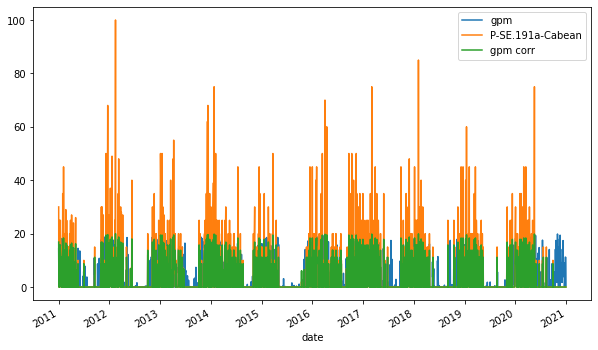

In [27]:
st24.plot(x="date", y=['gpm','P-SE.191a-Cabean','gpm corr'],
        kind="line", figsize=(10, 6))

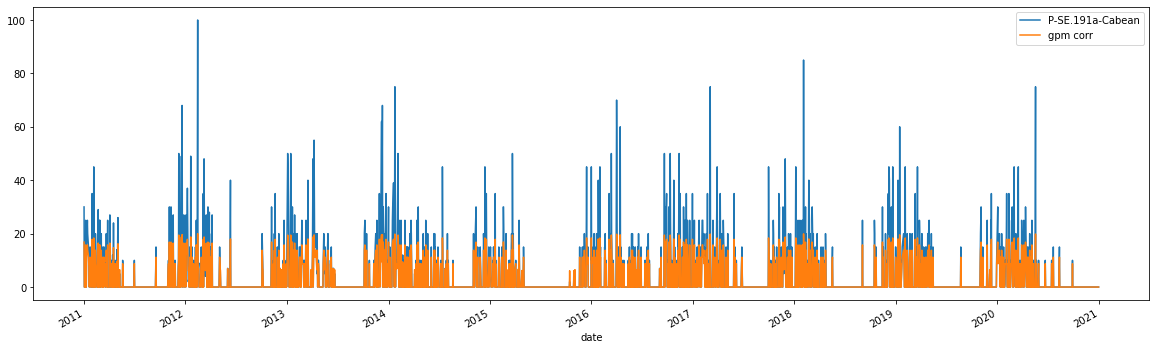

In [28]:
# setelah dikoreksi
st24.plot(x="date", y=['P-SE.191a-Cabean','gpm corr'],
        kind="line", figsize=(20, 6))

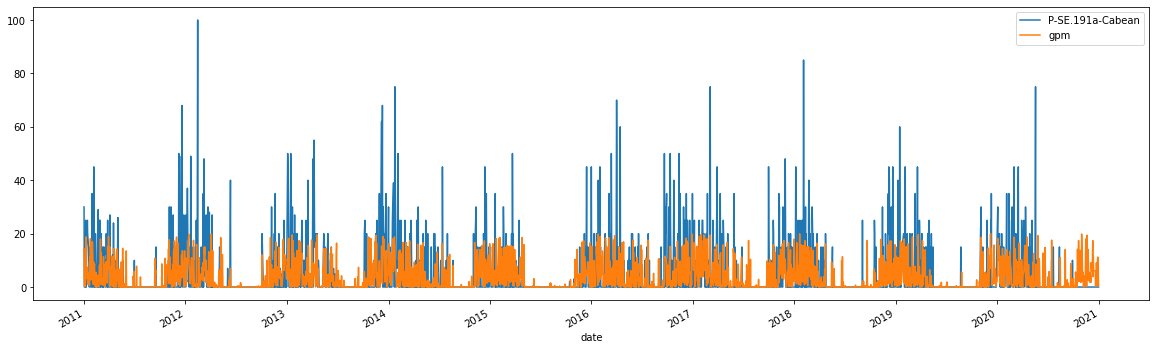

In [29]:
# sebelum dikoreksi
st24.plot(x="date", y=['P-SE.191a-Cabean','gpm'],
        kind="line", figsize=(20, 6))

In [30]:
tabel_performa=pd.DataFrame(columns=['stasiun','rmse','rmse corr','rmse wo otl','rmse wo otl corr',\
                                     'korelasi','korelasi corr','korelasi wo otl','korelasi wo otl corr'])
sta=pd.ExcelFile('D:/Happy/RTOW/Pemali Juana/koreksi gpm/ch klasifikasi acuan/qc_Ringan.xlsx')
sta_name=sta.sheet_names
for i in range (len(sta_name)):
    globals()['st'+str(i)]=pd.read_excel('D:/Happy/RTOW/Pemali Juana/koreksi gpm/ch klasifikasi acuan/qc_Ringan.xlsx',\
              sheet_name=sta_name[i])
    globals()['st'+str(i)]=globals()['st'+str(i)].dropna()
    obs_st=globals()['st'+str(i)].iloc[:,3]
    gpm_st=globals()['st'+str(i)].iloc[:,1]
    r1,p1=stats.pearsonr(obs_st, gpm_st)
    rmse1=mean_squared_error(obs_st, gpm_st)
    
    #quantileMapping Bias Correction
    gpm_corr=QuantileMappinBR(gpm_st,obs_st)
    r2,p2=stats.pearsonr(obs_st, gpm_corr)
    rmse2=mean_squared_error(obs_st, gpm_corr)
    
    #without outlier
    sss=globals()['st'+str(i)]
    globals()['st'+str(i)+'wo_otl']=sss[(sss.iloc[:,3]<250) & (sss.iloc[:,1]<250)]
    
    obs_st_wo_otl=globals()['st'+str(i)+'wo_otl'].iloc[:,3]
    gpm_st_wo_otl=globals()['st'+str(i)+'wo_otl'].iloc[:,1]
    r3,p3=stats.pearsonr(obs_st_wo_otl, gpm_st_wo_otl)
    rmse3=mean_squared_error(obs_st_wo_otl, gpm_st_wo_otl)
    
    #quantileMapping Bias Correction without outlier
    gpm_corr_wo_otl=QuantileMappinBR(obs_st_wo_otl, gpm_st_wo_otl)
    r4,p4=stats.pearsonr(obs_st_wo_otl, gpm_corr_wo_otl)
    rmse4=mean_squared_error(obs_st_wo_otl, gpm_corr_wo_otl)
    
    
    tabel_performa=tabel_performa.append(pd.DataFrame([{"stasiun":sta_name[i],
                    'rmse':rmse1,'rmse corr':rmse2,'rmse wo otl':rmse3,'rmse wo otl corr':rmse4,\
                    'korelasi':r1,'korelasi corr':r2,\
                    'korelasi wo otl':r3,'korelasi wo otl corr':r4}]))
tabel_performa=tabel_performa.reset_index()
tabel_performa=tabel_performa.iloc[:,1:]
tabel_performa

,stasiun,rmse,rmse corr,rmse wo otl,rmse wo otl corr,korelasi,korelasi corr,korelasi wo otl,korelasi wo otl corr
0,B-R.4b-Greneng,109.391918,44.573407,109.391918,185.330730,0.155110,0.806949,0.155110,0.078850
1,D-SE.110-Bungo,174.107429,91.583210,174.107429,303.266625,0.232337,0.838308,0.232337,0.151591
2,D-SE.117-Buyaran Karangsari,171.267864,83.983775,171.267864,296.358514,0.226004,0.854621,0.226004,0.145500
3,D-SE.124-Guntur,162.236896,79.814233,162.236896,285.731269,0.226542,0.835112,0.226542,0.130113
4,D-SE.165-Karanganyar,158.804638,76.913305,158.804638,266.940055,0.251352,0.891100,0.251352,0.179998
5,D-SE.166-Ngemplik,122.725469,53.804891,122.725469,208.837381,0.256987,0.870393,0.256987,0.171158
6,G-SE.133-Godong,139.655802,63.881551,139.655802,236.616532,0.228325,0.851505,0.228325,0.159635
7,G-SE.199-Gending,139.039401,63.077864,139.039401,243.656182,0.212511,0.842589,0.212511,0.117340
8,G-SE.201-Pengkol,102.251635,39.373815,102.251635,169.733040,0.190990,0.823610,0.190990,0.113748
9,G-SE.205b-Semen,152.585276,73.347871,152.585276,269.590452,0.199376,0.836699,0.199376,0.107943


In [31]:
## 

## CH Sedang

In [32]:
tabel_performa=pd.DataFrame(columns=['stasiun','rmse','rmse corr','rmse wo otl','rmse wo otl corr',\
                                     'korelasi','korelasi corr','korelasi wo otl','korelasi wo otl corr'])
sta=pd.ExcelFile('D:/Happy/RTOW/Pemali Juana/koreksi gpm/ch klasifikasi acuan/qc_Ringan.xlsx')
sta_name=sta.sheet_names

for i in range (len(sta_name)):
    globals()['st'+str(i)]=pd.read_excel('D:/Happy/RTOW/Pemali Juana/koreksi gpm/ch klasifikasi acuan/qc_Sedang.xlsx',\
              sheet_name=sta_name[i])
    globals()['st'+str(i)]=globals()['st'+str(i)].dropna()
    obs_st=globals()['st'+str(i)].iloc[:,3]
    gpm_st=globals()['st'+str(i)].iloc[:,1]
    r1,p1=stats.pearsonr(obs_st, gpm_st)
    rmse1=mean_squared_error(obs_st, gpm_st)
    
    #quantileMapping Bias Correction
    gpm_corr=QuantileMappinBR(gpm_st,obs_st)
    r2,p2=stats.pearsonr(obs_st, gpm_corr)
    rmse2=mean_squared_error(obs_st, gpm_corr)
    
    #without outlier
    sss=globals()['st'+str(i)]
    globals()['st'+str(i)+'wo_otl']=sss[(sss.iloc[:,3]<250) & (sss.iloc[:,1]<250)]
    
    obs_st_wo_otl=globals()['st'+str(i)+'wo_otl'].iloc[:,3]
    gpm_st_wo_otl=globals()['st'+str(i)+'wo_otl'].iloc[:,1]
    r3,p3=stats.pearsonr(obs_st_wo_otl, gpm_st_wo_otl)
    rmse3=mean_squared_error(obs_st_wo_otl, gpm_st_wo_otl)
    
    #quantileMapping Bias Correction without outlier
    gpm_corr_wo_otl=QuantileMappinBR(gpm_st_wo_otl, obs_st_wo_otl)
    r4,p4=stats.pearsonr(obs_st_wo_otl, gpm_corr_wo_otl)
    rmse4=mean_squared_error(obs_st_wo_otl, gpm_corr_wo_otl)
    
    
    tabel_performa=tabel_performa.append(pd.DataFrame([{"stasiun":sta_name[i],
                    'rmse':rmse1,'rmse corr':rmse2,'rmse wo otl':rmse3,'rmse wo otl corr':rmse4,\
                    'korelasi':r1,'korelasi corr':r2,\
                    'korelasi wo otl':r3,'korelasi wo otl corr':r4}]))
tabel_performa=tabel_performa.reset_index()
tabel_performa=tabel_performa.iloc[:,1:]
tabel_performa

,stasiun,rmse,rmse corr,rmse wo otl,rmse wo otl corr,korelasi,korelasi corr,korelasi wo otl,korelasi wo otl corr
0,B-R.4b-Greneng,728.626026,449.014200,728.626026,449.014200,-0.064366,0.870023,-0.064366,0.870023
1,D-SE.110-Bungo,765.040289,398.884813,765.040289,398.884813,0.031995,0.904005,0.031995,0.904005
2,D-SE.117-Buyaran Karangsari,774.270861,471.397477,774.270861,471.397477,0.059172,0.845694,0.059172,0.845694
3,D-SE.124-Guntur,798.291981,454.494720,798.291981,454.494720,0.001974,0.857607,0.001974,0.857607
4,D-SE.165-Karanganyar,866.762241,480.569107,866.762241,480.569107,-0.004596,0.855362,-0.004596,0.855362
5,D-SE.166-Ngemplik,709.872700,391.490065,709.872700,391.490065,0.067559,0.904269,0.067559,0.904269
6,G-SE.133-Godong,807.666330,453.897064,807.666330,453.897064,0.009364,0.847190,0.009364,0.847190
7,G-SE.199-Gending,743.237812,462.680322,743.237812,462.680322,0.083749,0.869872,0.083749,0.869872
8,G-SE.201-Pengkol,811.067634,526.515503,811.067634,526.515503,0.021126,0.791886,0.021126,0.791886
9,G-SE.205b-Semen,759.737693,457.618128,759.737693,457.618128,0.027906,0.850223,0.027906,0.850223


In [33]:
## sedang P-SE.181a-Gunung Rowo (indeks ke-21) (koreksinya dibalik)

In [34]:
tabel_performa=pd.DataFrame(columns=['stasiun','rmse','rmse corr','rmse wo otl','rmse wo otl corr',\
                                     'korelasi','korelasi corr','korelasi wo otl','korelasi wo otl corr'])
sta=pd.ExcelFile('D:/Happy/RTOW/Pemali Juana/koreksi gpm/ch klasifikasi acuan/qc_Ringan.xlsx')
sta_name=sta.sheet_names

for i in range (len(sta_name)):
    globals()['st'+str(i)]=pd.read_excel('D:/Happy/RTOW/Pemali Juana/koreksi gpm/ch klasifikasi acuan/qc_Sedang.xlsx',\
              sheet_name=sta_name[i])
    globals()['st'+str(i)]=globals()['st'+str(i)].dropna()
    obs_st=globals()['st'+str(i)].iloc[:,3]
    gpm_st=globals()['st'+str(i)].iloc[:,1]
    r1,p1=stats.pearsonr(obs_st, gpm_st)
    rmse1=mean_squared_error(obs_st, gpm_st)
    
    #quantileMapping Bias Correction
    gpm_corr=QuantileMappinBR(obs_st,gpm_st)
    r2,p2=stats.pearsonr(obs_st, gpm_corr)
    rmse2=mean_squared_error(obs_st, gpm_corr)
    
    #without outlier
    sss=globals()['st'+str(i)]
    globals()['st'+str(i)+'wo_otl']=sss[(sss.iloc[:,3]<250) & (sss.iloc[:,1]<250)]
    
    obs_st_wo_otl=globals()['st'+str(i)+'wo_otl'].iloc[:,3]
    gpm_st_wo_otl=globals()['st'+str(i)+'wo_otl'].iloc[:,1]
    r3,p3=stats.pearsonr(obs_st_wo_otl, gpm_st_wo_otl)
    rmse3=mean_squared_error(obs_st_wo_otl, gpm_st_wo_otl)
    
    #quantileMapping Bias Correction without outlier
    gpm_corr_wo_otl=QuantileMappinBR(obs_st_wo_otl,gpm_st_wo_otl)
    r4,p4=stats.pearsonr(obs_st_wo_otl, gpm_corr_wo_otl)
    rmse4=mean_squared_error(obs_st_wo_otl, gpm_corr_wo_otl)
    
    
    tabel_performa=tabel_performa.append(pd.DataFrame([{"stasiun":sta_name[i],
                    'rmse':rmse1,'rmse corr':rmse2,'rmse wo otl':rmse3,'rmse wo otl corr':rmse4,\
                    'korelasi':r1,'korelasi corr':r2,\
                    'korelasi wo otl':r3,'korelasi wo otl corr':r4}]))
tabel_performa=tabel_performa.reset_index()
tabel_performa=tabel_performa.iloc[:,1:]
tabel_performa

,stasiun,rmse,rmse corr,rmse wo otl,rmse wo otl corr,korelasi,korelasi corr,korelasi wo otl,korelasi wo otl corr
0,B-R.4b-Greneng,728.626026,414.782609,728.626026,414.782609,-0.064366,-0.079595,-0.064366,-0.079595
1,D-SE.110-Bungo,765.040289,959.111111,765.040289,959.111111,0.031995,0.016016,0.031995,0.016016
2,D-SE.117-Buyaran Karangsari,774.270861,678.416901,774.270861,678.416901,0.059172,0.002677,0.059172,0.002677
3,D-SE.124-Guntur,798.291981,743.092958,798.291981,743.092958,0.001974,-0.051637,0.001974,-0.051637
4,D-SE.165-Karanganyar,866.762241,1091.367781,866.762241,1091.367781,-0.004596,-0.022910,-0.004596,-0.022910
5,D-SE.166-Ngemplik,709.872700,754.644377,709.872700,754.644377,0.067559,0.036219,0.067559,0.036219
6,G-SE.133-Godong,807.666330,606.775956,807.666330,606.775956,0.009364,-0.014626,0.009364,-0.014626
7,G-SE.199-Gending,743.237812,377.466307,743.237812,377.466307,0.083749,0.035629,0.083749,0.035629
8,G-SE.201-Pengkol,811.067634,312.091139,811.067634,312.091139,0.021126,-0.015139,0.021126,-0.015139
9,G-SE.205b-Semen,759.737693,531.392405,759.737693,531.392405,0.027906,-0.001659,0.027906,-0.001659


In [35]:
## 

## Faktor Koreksi

In [36]:
from bias_correction import BiasCorrection, XBiasCorrection

In [37]:
from sklearn.model_selection import train_test_split
import glob

## Ringan

In [38]:
path=r'D:\Happy\RTOW\Pemali Juana\koreksi gpm\klasifikasi ch\kebutuhan'
ringan_tb_corr = glob.glob(path + "/*qc_ringan*.xlsx")
ringan_tb_corr

['D:\\Happy\\RTOW\\Pemali Juana\\koreksi gpm\\klasifikasi ch\\kebutuhan\\qc_Ringan_DI_Klambu.xlsx',
 'D:\\Happy\\RTOW\\Pemali Juana\\koreksi gpm\\klasifikasi ch\\kebutuhan\\qc_Ringan_DI_Sedadi.xlsx',
 'D:\\Happy\\RTOW\\Pemali Juana\\koreksi gpm\\klasifikasi ch\\kebutuhan\\qc_Ringan_DI_Sidorejo.xlsx',
 'D:\\Happy\\RTOW\\Pemali Juana\\koreksi gpm\\klasifikasi ch\\kebutuhan\\qc_Ringan_Klambu.xlsx',
 'D:\\Happy\\RTOW\\Pemali Juana\\koreksi gpm\\klasifikasi ch\\kebutuhan\\qc_Ringan_Sedadi.xlsx',
 'D:\\Happy\\RTOW\\Pemali Juana\\koreksi gpm\\klasifikasi ch\\kebutuhan\\qc_Ringan_Sidorejo.xlsx']

In [39]:
ringan_tb_corr[-1][74:-5]

'Sidorejo'

In [40]:
## RINGAN
path=r'D:\Happy\RTOW\Pemali Juana\koreksi gpm\klasifikasi ch\kebutuhan'
ringan_tb_corr = glob.glob(path + "/*qc_ringan*.xlsx")

for model_excel in ringan_tb_corr:
    #ini harus di-loop untuk menyimpan data excel gpm per model untuk dikoreksi
    xls = pd.ExcelFile(model_excel)
    # Now you can list all sheets in the file
    gages=xls.sheet_names
    print (gages)
    model_gpm=model_excel[74:-5]
    print (model_gpm)

    for gage in gages: #loop for each gage in model
        print (gage)
        globals()[model_gpm+"_ringan_"+gage]=pd.read_excel(model_excel,sheet_name=gage)
        globals()[model_gpm+"_ringan_"+gage]=globals()[model_gpm+"_ringan_"+gage].iloc[:,1:]

        path='D:/Happy/RTOW/Pemali Juana/koreksi gpm/ch klasifikasi acuan'

        #ini harus di-loop untuk tiap stasiun obs ter-qc (untuk reference bias correction data yg harus dikoreksi)
        globals()['st'+str(24)]=pd.read_excel(path+'/qc_Ringan.xlsx',sheet_name=24)
        obs_st=globals()['st'+str(24)].iloc[:,3]
        gpm_st=globals()['st'+str(24)].iloc[:,1]

        bc = BiasCorrection(gpm_st,obs_st,globals()[model_gpm+"_ringan_"+gage].loc[:,gage])
        corrected = bc.correct(method='basic_quantile')
        #simpan corrected ke dalam tambahan tabel
        globals()[model_gpm+"_ringan_"+gage]["gpm terkoreksi"]=corrected
        globals()[model_gpm+"_ringan_"+gage]['date'] = \
        pd.to_datetime(globals()[model_gpm+"_ringan_"+gage]['date'])

['Klambu4', 'Klambu5', 'Klambu7', 'Klambu8', 'Klambu9', 'Klambu10', 'Klambu12', 'Klambu13', 'Klambu15', 'Klambu16', 'Klambu19', 'Klambu20']
DI_Klambu
Klambu4
Klambu5
Klambu7
Klambu8
Klambu9
Klambu10
Klambu12
Klambu13
Klambu15
Klambu16
Klambu19
Klambu20
['Sedadi2', 'Sedadi3', 'Sedadi4', 'Sedadi5', 'Sedadi6', 'Sedadi7', 'Sedadi8', 'Sedadi9']
DI_Sedadi
Sedadi2
Sedadi3
Sedadi4
Sedadi5
Sedadi6
Sedadi7
Sedadi8
Sedadi9
['Sidorejo3']
DI_Sidorejo
Sidorejo3
['S1', 'S3', 'S4', 'S5', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 'S21', 'S23', 'S24', 'S25', 'S26', 'S27', 'S30', 'S31', 'S34', 'S35', 'S36', 'S37', 'S39', 'S42', 'S43']
Klambu
S1
S3
S4
S5
S7
S8
S9
S10
S11
S12
S14
S15
S16
S17
S18
S19
S20
S21
S23
S24
S25
S26
S27
S30
S31
S34
S35
S36
S37
S39
S42
S43
['s6', 's7', 's8', 's12', 's13', 's14', 's15', 's19', 's20', 's21', 's22', 's25', 's26', 's27', 's32', 's33', 's34', 's37', 's38', 's39']
Sedadi
s6
s7
s8
s12
s13
s14
s15
s19
s20
s21
s22
s25
s26
s27
s32


In [41]:
globals()[model_gpm+"_ringan_"+gage]

,date,Sidorejo1,Klasifikasi,gpm terkoreksi
0,2000-06-01,15.161672,Ringan,12.283715
1,2000-06-02,0.000000,Ringan,5.869381
2,2000-06-03,0.000000,Ringan,5.869381
3,2000-06-04,11.265001,Ringan,9.506073
4,2000-06-05,16.738161,Ringan,13.860204
...,...,...,...,...
7311,2022-01-27,0.101423,Ringan,5.970804
7312,2022-01-28,0.298524,Ringan,6.167905
7313,2022-01-29,4.041535,Ringan,6.052613
7314,2022-01-30,4.059350,Ringan,6.070427


## Sedang

In [42]:
path=r'D:\Happy\RTOW\Pemali Juana\koreksi gpm\klasifikasi ch\kebutuhan'
ringan_tb_corr = glob.glob(path + "/*qc_sedang*.xlsx")
ringan_tb_corr

['D:\\Happy\\RTOW\\Pemali Juana\\koreksi gpm\\klasifikasi ch\\kebutuhan\\qc_Sedang_DI_Klambu.xlsx',
 'D:\\Happy\\RTOW\\Pemali Juana\\koreksi gpm\\klasifikasi ch\\kebutuhan\\qc_Sedang_DI_Sedadi.xlsx',
 'D:\\Happy\\RTOW\\Pemali Juana\\koreksi gpm\\klasifikasi ch\\kebutuhan\\qc_Sedang_DI_Sidorejo.xlsx',
 'D:\\Happy\\RTOW\\Pemali Juana\\koreksi gpm\\klasifikasi ch\\kebutuhan\\qc_Sedang_Klambu.xlsx',
 'D:\\Happy\\RTOW\\Pemali Juana\\koreksi gpm\\klasifikasi ch\\kebutuhan\\qc_Sedang_Sedadi.xlsx',
 'D:\\Happy\\RTOW\\Pemali Juana\\koreksi gpm\\klasifikasi ch\\kebutuhan\\qc_Sedang_Sidorejo.xlsx']

In [43]:
ringan_tb_corr[0][74:-5]

'DI_Klambu'

In [44]:
## SEDANG
path=r'D:\Happy\RTOW\Pemali Juana\koreksi gpm\klasifikasi ch\kebutuhan'
ringan_tb_corr = glob.glob(path + "/*qc_sedang*.xlsx")

for model_excel in ringan_tb_corr:
    #ini harus di-loop untuk menyimpan data excel gpm per model untuk dikoreksi
    xls = pd.ExcelFile(model_excel)
    # Now you can list all sheets in the file
    gages=xls.sheet_names
    print (gages)
    model_gpm=model_excel[74:-5]
    print (model_gpm)

    for gage in gages: #loop for each gage in model
        print (gage)
        globals()[model_gpm+"_sedang_"+gage]=pd.read_excel(model_excel,sheet_name=gage)
        globals()[model_gpm+"_sedang_"+gage]=globals()[model_gpm+"_sedang_"+gage].iloc[:,1:]

        path='D:/Happy/RTOW/Pemali Juana/koreksi gpm/ch klasifikasi acuan'

        #ini harus di-loop untuk tiap stasiun obs ter-qc (untuk reference bias correction data yg harus dikoreksi)
        globals()['st'+str(21)]=pd.read_excel(path+'/qc_Sedang.xlsx',sheet_name=21)
        obs_st=globals()['st'+str(21)].iloc[:,3]
        gpm_st=globals()['st'+str(21)].iloc[:,1]

        bc = BiasCorrection(gpm_st, obs_st, globals()[model_gpm+"_sedang_"+gage].loc[:,gage])
        corrected = bc.correct(method='basic_quantile')
        #simpan corrected ke dalam tambahan tabel
        globals()[model_gpm+"_sedang_"+gage]["gpm terkoreksi"]=corrected
        globals()[model_gpm+"_sedang_"+gage]['date'] = \
        pd.to_datetime(globals()[model_gpm+"_sedang_"+gage]['date'])

['Klambu4', 'Klambu5', 'Klambu7', 'Klambu8', 'Klambu9', 'Klambu10', 'Klambu12', 'Klambu13', 'Klambu15', 'Klambu16', 'Klambu19', 'Klambu20']
DI_Klambu
Klambu4
Klambu5
Klambu7
Klambu8
Klambu9
Klambu10
Klambu12
Klambu13
Klambu15
Klambu16
Klambu19
Klambu20
['Sedadi2', 'Sedadi3', 'Sedadi4', 'Sedadi5', 'Sedadi6', 'Sedadi7', 'Sedadi8', 'Sedadi9']
DI_Sedadi
Sedadi2
Sedadi3
Sedadi4
Sedadi5
Sedadi6
Sedadi7
Sedadi8
Sedadi9
['Sidorejo3']
DI_Sidorejo
Sidorejo3
['S1', 'S3', 'S4', 'S5', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 'S21', 'S23', 'S24', 'S25', 'S26', 'S27', 'S30', 'S31', 'S34', 'S35', 'S36', 'S37', 'S39', 'S42', 'S43']
Klambu
S1
S3
S4
S5
S7
S8
S9
S10
S11
S12
S14
S15
S16
S17
S18
S19
S20
S21
S23
S24
S25
S26
S27
S30
S31
S34
S35
S36
S37
S39
S42
S43
['s6', 's7', 's8', 's12', 's13', 's14', 's15', 's19', 's20', 's21', 's22', 's25', 's26', 's27', 's32', 's33', 's34', 's37', 's38', 's39']
Sedadi
s6
s7
s8
s12
s13
s14
s15
s19
s20
s21
s22
s25
s26
s27
s32


In [45]:
globals()[model_gpm+"_sedang_"+gage]

,date,Sidorejo1,Klasifikasi,gpm terkoreksi
0,2000-06-19,44.244095,Sedang,45.901906
1,2000-06-23,30.098145,Sedang,38.734304
2,2000-06-24,32.521477,Sedang,40.081578
3,2000-06-25,41.191422,Sedang,44.168446
4,2000-07-03,22.358297,Sedang,36.495391
...,...,...,...,...
421,2021-12-24,31.923191,Sedang,39.758723
422,2021-12-25,27.951368,Sedang,38.709372
423,2022-01-05,23.923641,Sedang,37.300702
424,2022-01-17,21.045164,Sedang,35.683097


## Lebat

In [46]:
path=r'D:\Happy\RTOW\Pemali Juana\koreksi gpm\klasifikasi ch\kebutuhan'
ringan_tb_corr = glob.glob(path + "/*qc_lebat*.xlsx")
ringan_tb_corr

['D:\\Happy\\RTOW\\Pemali Juana\\koreksi gpm\\klasifikasi ch\\kebutuhan\\qc_Lebat_DI_Klambu.xlsx',
 'D:\\Happy\\RTOW\\Pemali Juana\\koreksi gpm\\klasifikasi ch\\kebutuhan\\qc_Lebat_DI_Sedadi.xlsx',
 'D:\\Happy\\RTOW\\Pemali Juana\\koreksi gpm\\klasifikasi ch\\kebutuhan\\qc_Lebat_DI_Sidorejo.xlsx',
 'D:\\Happy\\RTOW\\Pemali Juana\\koreksi gpm\\klasifikasi ch\\kebutuhan\\qc_Lebat_Klambu.xlsx',
 'D:\\Happy\\RTOW\\Pemali Juana\\koreksi gpm\\klasifikasi ch\\kebutuhan\\qc_Lebat_Sedadi.xlsx',
 'D:\\Happy\\RTOW\\Pemali Juana\\koreksi gpm\\klasifikasi ch\\kebutuhan\\qc_Lebat_Sidorejo.xlsx',
 'D:\\Happy\\RTOW\\Pemali Juana\\koreksi gpm\\klasifikasi ch\\kebutuhan\\~$qc_Lebat_DI_Klambu.xlsx']

In [47]:
ringan_tb_corr[0][73:-5]

'DI_Klambu'

In [49]:
## LEBAT
path=r'D:\Happy\RTOW\Pemali Juana\koreksi gpm\klasifikasi ch\kebutuhan'
ringan_tb_corr = glob.glob(path + "/*qc_lebat*.xlsx")

for model_excel in ringan_tb_corr:
    #ini harus di-loop untuk menyimpan data excel gpm per model untuk dikoreksi
    xls = pd.ExcelFile(model_excel)
    # Now you can list all sheets in the file
    gages=xls.sheet_names
    print (gages)
    model_gpm=model_excel[73:-5]
    print (model_gpm)

    for gage in gages: #loop for each gage in model
        print (gage)
        globals()[model_gpm+"_lebat_"+gage]=pd.read_excel(model_excel,sheet_name=gage)
        globals()[model_gpm+"_lebat_"+gage]=globals()[model_gpm+"_lebat_"+gage].iloc[:,1:]

        path='D:/Happy/RTOW/Pemali Juana/koreksi gpm/ch klasifikasi acuan'

        #ini harus di-loop untuk tiap stasiun obs ter-qc (untuk reference bias correction data yg harus dikoreksi)
        globals()['st'+str(7)]=pd.read_excel(path+'/qc_Lebat.xlsx',sheet_name=7)
        obs_st=globals()['st'+str(7)].iloc[:,3]
        gpm_st=globals()['st'+str(7)].iloc[:,1]

        bc = BiasCorrection(gpm_st, obs_st, globals()[model_gpm+"_lebat_"+gage].loc[:,gage])
        corrected = bc.correct(method='basic_quantile')
        #simpan corrected ke dalam tambahan tabel
        globals()[model_gpm+"_lebat_"+gage]["gpm terkoreksi"]=corrected
        globals()[model_gpm+"_lebat_"+gage]['date'] = \
        pd.to_datetime(globals()[model_gpm+"_lebat_"+gage]['date'])

['Klambu4', 'Klambu5', 'Klambu7', 'Klambu8', 'Klambu9', 'Klambu10', 'Klambu12', 'Klambu13', 'Klambu15', 'Klambu16', 'Klambu19', 'Klambu20']
DI_Klambu
Klambu4
Klambu5
Klambu7
Klambu8
Klambu9
Klambu10
Klambu12
Klambu13
Klambu15
Klambu16
Klambu19
Klambu20
['Sedadi2', 'Sedadi3', 'Sedadi4', 'Sedadi5', 'Sedadi6', 'Sedadi7', 'Sedadi8', 'Sedadi9']
DI_Sedadi
Sedadi2
Sedadi3
Sedadi4
Sedadi5
Sedadi6
Sedadi7
Sedadi8
Sedadi9
['Sidorejo3']
DI_Sidorejo
Sidorejo3
['S1', 'S3', 'S4', 'S5', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 'S21', 'S23', 'S24', 'S25', 'S26', 'S27', 'S30', 'S31', 'S34', 'S35', 'S36', 'S37', 'S39', 'S42', 'S43']
Klambu
S1
S3
S4
S5
S7
S8
S9
S10
S11
S12
S14
S15
S16
S17
S18
S19
S20
S21
S23
S24
S25
S26
S27
S30
S31
S34
S35
S36
S37
S39
S42
S43
['s6', 's7', 's8', 's12', 's13', 's14', 's15', 's19', 's20', 's21', 's22', 's25', 's26', 's27', 's32', 's33', 's34', 's37', 's38', 's39']
Sedadi
s6
s7
s8
s12
s13
s14
s15
s19
s20
s21
s22
s25
s26
s27
s32


In [50]:
globals()[model_gpm+"_lebat_"+gage]

,date,Sidorejo1,Klasifikasi,gpm terkoreksi
0,2000-06-10,58.326481,Lebat,128.137615
1,2000-06-21,54.259350,Lebat,124.070484
2,2000-11-30,87.297989,Lebat,157.109123
3,2000-12-16,65.168167,Lebat,134.979301
4,2001-01-10,72.718224,Lebat,142.529358
...,...,...,...,...
115,2021-08-27,61.027023,Lebat,130.838158
116,2021-11-18,74.752777,Lebat,144.563911
117,2021-12-21,67.657333,Lebat,137.468468
118,2021-12-22,78.847977,Lebat,148.659111


## Sangat Lebat

In [51]:
path=r'D:\Happy\RTOW\Pemali Juana\koreksi gpm\klasifikasi ch\kebutuhan'
ringan_tb_corr = glob.glob(path + "/*sangat_lebat*.xlsx")
ringan_tb_corr

['D:\\Happy\\RTOW\\Pemali Juana\\koreksi gpm\\klasifikasi ch\\kebutuhan\\qc_Sangat_Lebat_DI_Klambu.xlsx',
 'D:\\Happy\\RTOW\\Pemali Juana\\koreksi gpm\\klasifikasi ch\\kebutuhan\\qc_Sangat_Lebat_DI_Sedadi.xlsx',
 'D:\\Happy\\RTOW\\Pemali Juana\\koreksi gpm\\klasifikasi ch\\kebutuhan\\qc_Sangat_Lebat_DI_Sidorejo.xlsx',
 'D:\\Happy\\RTOW\\Pemali Juana\\koreksi gpm\\klasifikasi ch\\kebutuhan\\qc_Sangat_Lebat_Klambu.xlsx',
 'D:\\Happy\\RTOW\\Pemali Juana\\koreksi gpm\\klasifikasi ch\\kebutuhan\\qc_Sangat_Lebat_Sedadi.xlsx',
 'D:\\Happy\\RTOW\\Pemali Juana\\koreksi gpm\\klasifikasi ch\\kebutuhan\\qc_Sangat_Lebat_Sidorejo.xlsx']

In [52]:
ringan_tb_corr[0][80:-5]

'DI_Klambu'

In [53]:
## SANGAT LEBAT
path=r'D:\Happy\RTOW\Pemali Juana\koreksi gpm\klasifikasi ch\kebutuhan'
ringan_tb_corr = glob.glob(path + "/*sangat_lebat*.xlsx")

for model_excel in ringan_tb_corr:
    #ini harus di-loop untuk menyimpan data excel gpm per model untuk dikoreksi
    xls = pd.ExcelFile(model_excel)
    # Now you can list all sheets in the file
    gages=xls.sheet_names
    print (gages)
    model_gpm=model_excel[80:-5]
    print (model_gpm)

    for gage in gages: #loop for each gage in model
        print (gage)
        globals()[model_gpm+"_sangat_lebat_"+gage]=pd.read_excel(model_excel,sheet_name=gage)
        globals()[model_gpm+"_sangat_lebat_"+gage]=globals()[model_gpm+"_sangat_lebat_"+gage].iloc[:,1:]

        path='D:/Happy/RTOW/Pemali Juana/koreksi gpm/ch klasifikasi acuan'

        #ini harus di-loop untuk tiap stasiun obs ter-qc (untuk reference bias correction data yg harus dikoreksi)
        globals()['st'+str(14)]=pd.read_excel(path+'/qc_Sangat_Lebat.xlsx',sheet_name=14)
        obs_st=globals()['st'+str(14)].iloc[:,3]
        gpm_st=globals()['st'+str(14)].iloc[:,1]

        bc = BiasCorrection(gpm_st, obs_st, globals()[model_gpm+"_sangat_lebat_"+gage].loc[:,gage])
        corrected = bc.correct(method='basic_quantile')
        #simpan corrected ke dalam tambahan tabel
        globals()[model_gpm+"_sangat_lebat_"+gage]["gpm terkoreksi"]=corrected
        globals()[model_gpm+"_sangat_lebat_"+gage]['date'] = \
        pd.to_datetime(globals()[model_gpm+"_sangat_lebat_"+gage]['date'])

['Klambu4', 'Klambu5', 'Klambu7', 'Klambu8', 'Klambu9', 'Klambu10', 'Klambu12', 'Klambu13', 'Klambu15', 'Klambu16', 'Klambu19', 'Klambu20']
DI_Klambu
Klambu4
Klambu5
Klambu7
Klambu8
Klambu9
Klambu10
Klambu12
Klambu13
Klambu15
Klambu16
Klambu19
Klambu20
['Sedadi2', 'Sedadi3', 'Sedadi4', 'Sedadi5', 'Sedadi6', 'Sedadi7', 'Sedadi8', 'Sedadi9']
DI_Sedadi
Sedadi2
Sedadi3
Sedadi4
Sedadi5
Sedadi6
Sedadi7
Sedadi8
Sedadi9
['Sidorejo3']
DI_Sidorejo
Sidorejo3
['S1', 'S3', 'S4', 'S5', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 'S21', 'S23', 'S24', 'S25', 'S26', 'S27', 'S30', 'S31', 'S34', 'S35', 'S36', 'S37', 'S39', 'S42', 'S43']
Klambu
S1
S3
S4
S5
S7
S8
S9
S10
S11
S12
S14
S15
S16
S17
S18
S19
S20
S21
S23
S24
S25
S26
S27
S30
S31
S34
S35
S36
S37
S39
S42
S43
['s6', 's7', 's8', 's12', 's13', 's14', 's15', 's19', 's20', 's21', 's22', 's25', 's26', 's27', 's32', 's33', 's34', 's37', 's38', 's39']
Sedadi
s6
s7
s8
s12
s13
s14
s15
s19
s20
s21
s22
s25
s26
s27
s32


In [54]:
globals()[model_gpm+"_sangat_lebat_"+gage].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            53 non-null     datetime64[ns]
 1   Sidorejo1       53 non-null     float64       
 2   Klasifikasi     53 non-null     object        
 3   gpm terkoreksi  53 non-null     float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 1.8+ KB


In [55]:
globals()[model_gpm+"_lebat_"+gage].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            120 non-null    datetime64[ns]
 1   Sidorejo1       120 non-null    float64       
 2   Klasifikasi     120 non-null    object        
 3   gpm terkoreksi  120 non-null    float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 3.9+ KB
